In [1]:
# import torch
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

统计指标的计算函数（pandas读取）  
时间耗费大，因为是遍历dataframe

In [2]:
def compute_metrics_pd(df):
    global r_average
    for i,row in df.iterrows():
        rating = row['rating']
        uid = row['uid']
        iid = row['iid']
        if u_r_averages.get(uid,-1) == -1:
            u_r_averages[uid] = rating
            u_r_count[uid] = 1
        else:
            u_r_averages[uid] += rating
            u_r_count[uid] += 1
        if i_r_averages.get(iid,-1) == -1:
            i_r_averages[iid] = rating
            i_r_count[iid] = 1
        else:
            i_r_averages[iid] += rating
            i_r_count[iid] += 1
        r_average += rating
    r_average /= len(df)
    for iid in i_r_averages:
        i_r_averages[iid] = round(i_r_averages[iid] / i_r_count[iid],4)
    for uuid in u_r_averages:
        u_r_averages[uuid] = round(u_r_averages[uuid] / u_r_count[uuid],4)
    #待用户和物品平均分计算完后，计算用户和物品偏置
    for i,row in df.iterrows():
        rating = row['rating']
        uid = row['uid']
        iid = row['iid']
        if u_biass.get(uid,-1) == -1:
            u_biass[uid] = rating - i_r_averages[iid]
        else:
            u_biass[uid] += rating - i_r_averages[iid]
        if i_biass.get(iid,-1) == -1:
            i_biass[iid] = rating - u_r_averages[uid]
        else:
            i_biass[iid] += rating - u_r_averages[uid]
        if u_variance.get(uid,-1) == -1:
            u_variance[uid] = (u_r_averages[uid] - rating)**2
        else:
            u_variance[uid] += (u_r_averages[uid] - rating)**2
    for uuid in u_biass:
        u_biass[uuid] = round(u_biass[uuid] /  u_r_count[uuid],4)
        u_variance[uuid] = math.sqrt(round(u_variance[uuid] /  u_r_count[uuid],4))
    for iid in i_biass:
        i_biass[iid] = round(i_biass[iid] /  i_r_count[iid],4)

统计指标的计算函数（文件流读取）

In [3]:
def compute_metrics_file(path):
    global r_average
    with open(path, "r") as file:
        lines = file.readlines()
    #     print("user id | item id | rating | timestamp")
        for i in range(len(lines)):
            rating = int(lines[i].split()[2])
            uid = int(lines[i].split()[0])
            iid = int(lines[i].split()[1])
            if u_r_averages.get(uid,-1) == -1:
                u_r_averages[uid] = rating
                u_r_count[uid] = 1
            else:
                u_r_averages[uid] += rating
                u_r_count[uid] += 1
            if i_r_averages.get(iid,-1) == -1:
                i_r_averages[iid] = rating
                i_r_count[iid] = 1
            else:
                i_r_averages[iid] += rating
                i_r_count[iid] += 1
            r_average += rating
        r_average /= len(lines)
        for iid in i_r_averages:
            i_r_averages[iid] = round(i_r_averages[iid] / i_r_count[iid],4)
        for uuid in u_r_averages:
            u_r_averages[uuid] = round(u_r_averages[uuid] / u_r_count[uuid],4)
        #待用户和物品平均分计算完后，计算用户和物品偏置
        for i in range(len(lines)):
            rating = int(lines[i].split()[2])
            uid = int(lines[i].split()[0])
            iid = int(lines[i].split()[1])
            if u_biass.get(uid,-1) == -1:
                u_biass[uid] = rating - i_r_averages[iid]
            else:
                u_biass[uid] += rating - i_r_averages[iid]
            if i_biass.get(iid,-1) == -1:
                i_biass[iid] = rating - u_r_averages[uid]
            else:
                i_biass[iid] += rating - u_r_averages[uid]
        for uuid in u_biass:
            u_biass[uuid] = round(u_biass[uuid] /  u_r_count[uuid],4)
        for iid in i_biass:
            i_biass[iid] = round(i_biass[iid] /  i_r_count[iid],4)

测试集共459个用户的20000条评分记录

In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [5]:
def af(style,path):
    mae_af = 0
    rmse_af = 0
    with open(path, "r") as file:
        lines = file.readlines()
        for i in range(len(lines)):
            uid = int(lines[i].split()[0])
            iid = int(lines[i].split()[1])
            # 如果训练集中缺失某个用户或者某个物品的记录，则该用户或者物品的平均分默认为全局平均分
            u_r_average = r_average if u_r_averages.get(uid,-1) == -1 else u_r_averages[uid]
            i_r_average = r_average if i_r_averages.get(iid,-1) == -1 else i_r_averages[iid]
            u_bias = 0 if u_biass.get(uid,-1) == -1 else u_biass[uid]
            i_bias = 0 if i_biass.get(iid,-1) == -1 else i_biass[iid]
            #自己补充的一个指标，表示标准差或者方差
            u_var = 0 if u_variance.get(uid,-1) == -1 else u_variance[uid]
            if style == 1:
                predict_u_r = u_r_average
            elif style == 2:
                predict_u_r = i_r_average
            elif style == 3:
                predict_u_r = u_r_average/2 + i_r_average/2
            elif style == 4:
                predict_u_r = i_r_average + u_bias 
            elif style == 5:
                predict_u_r = u_r_average + i_bias
            elif style == 6:
                predict_u_r = r_average + i_bias + u_bias
            mae_af += abs(int(lines[i].split()[2])-predict_u_r)
            rmse_af += pow(int(lines[i].split()[2])-predict_u_r,2)
        mae_af /= len(lines)
        rmse_af /= len(lines)
        rmse_af = math.sqrt(rmse_af)
        return round(mae_af,4), round(rmse_af,4)

In [6]:
# 全局平均分
r_average = 0
# 每个用户的评分的平均值
u_r_averages = {}
# 每个用户的评分总数
u_r_count = {}
# 每个物品的评分的平均值
i_r_averages = {}
i_r_count = {}
u_biass = {}
i_biass = {}
u_variance = {}
# compute_metrics_file("datasets/ml-100k/u1.base")
trainData = pd.read_csv("datasets/ml-100k/u1.base",sep='\t',names=['uid','iid','rating','time'])
compute_metrics_pd(trainData)
af(4,"datasets/ml-100k/u1.test")

(0.7574, 0.9602)

In [7]:
u_r_averages

{1: 3.6815,
 2: 3.8,
 3: 3.0,
 4: 4.3571,
 5: 2.956,
 6: 3.5818,
 7: 3.892,
 8: 3.6,
 9: 4.1667,
 10: 4.2128,
 11: 3.5333,
 12: 4.28,
 13: 3.1367,
 14: 4.2195,
 15: 3.0333,
 16: 4.3478,
 17: 3.1579,
 18: 3.9371,
 19: 3.6,
 20: 3.3077,
 21: 2.6632,
 22: 3.3,
 23: 3.6364,
 24: 4.3902,
 25: 4.0488,
 26: 2.9091,
 27: 3.3,
 28: 3.641,
 29: 3.9412,
 30: 3.8,
 31: 3.913,
 32: 3.5455,
 33: 3.6429,
 34: 3.8,
 35: 3.0,
 36: 4.0,
 37: 3.4595,
 38: 3.9048,
 39: 3.8462,
 40: 2.7273,
 41: 3.9355,
 42: 3.625,
 43: 3.6786,
 44: 3.6375,
 45: 3.4828,
 46: 4.1818,
 47: 3.5625,
 48: 3.7273,
 49: 2.729,
 50: 3.5385,
 51: 3.75,
 52: 4.3429,
 53: 4.0,
 54: 3.3333,
 55: 3.8,
 56: 3.6522,
 57: 3.6296,
 58: 3.875,
 59: 4.0233,
 60: 4.1345,
 61: 2.8333,
 62: 3.3171,
 63: 2.9792,
 64: 3.5963,
 65: 3.9792,
 66: 3.5238,
 67: 3.4167,
 68: 3.1667,
 69: 3.7368,
 70: 3.4026,
 71: 3.8182,
 72: 3.7671,
 73: 3.6471,
 74: 3.7619,
 75: 3.1818,
 76: 3.4,
 77: 3.4615,
 78: 3.3571,
 79: 4.1852,
 80: 3.9286,
 81: 3.5667,
 82: 3

In [60]:
da = np.array(list(u_variance.values())).reshape(1,-1)

In [63]:
from sklearn.preprocessing import StandardScaler
#区间缩放，返回值为缩放到[0,1]区间的数据
StandardScaler().fit_transform(da)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [27]:
var = sum([(3.6815-i)**2 for i in list(trainData[trainData['uid']==1]['rating'])])
var

219.30370374999967

对测试集中的用户按照不同活跃度分组测试。每组再用不同的验证标准测试

In [6]:
df = pd.read_csv("datasets/ml-100k/u1.test",sep='\t',names=['uid','iid','rating','time'])
userRatingCount = df['uid'].value_counts().sort_values(ascending=False)
cut_series = pd.cut(userRatingCount, bins=[0, 20, 50,max(userRatingCount)], labels=['Low', 'Medium', 'High'])
grouped_data = userRatingCount.groupby(cut_series)

In [7]:
for label, group_data in grouped_data:
    uids = group_data.index
    tempDF = df[df['uid'].isin(uids)]
    print(len(tempDF))

2201
3780
14019


In [7]:
RMSE = []
MAE = []
for style in range(1,7):
    temp_rmse = []
    temp_mae = []
    for label, group_data in grouped_data:
        r_average = 0
        u_r_averages = {}
        u_r_count = {}
        i_r_averages = {}
        i_r_count = {}
        u_biass = {}
        i_biass = {}
        print(f"分箱标签: {label}")
        uids = group_data.index
        tempDF = df[df['uid'].isin(uids)]
        compute_metrics_pd(tempDF)
        temp = af(style,"datasets/ml-100k/u1.test")
        temp_mae.append(temp[0])
        temp_rmse.append(temp[1])
    MAE.append(temp_mae)
    RMSE.append(temp_rmse)

分箱标签: Low
分箱标签: Medium
分箱标签: High
分箱标签: Low
分箱标签: Medium
分箱标签: High
分箱标签: Low
分箱标签: Medium
分箱标签: High
分箱标签: Low
分箱标签: Medium
分箱标签: High
分箱标签: Low
分箱标签: Medium
分箱标签: High
分箱标签: Low
分箱标签: Medium
分箱标签: High


In [137]:
for label, group_data in grouped_data:
    print(label)
    print(group_data)
# #     print(group_data.index)
#     uids = list(group_data.index)
#     uids.sort()
#     print(uids)
#     print(df[df['uid'].isin(uids)].head(20))
#     break

Low
37     20
365    20
218    20
272    20
382    20
       ..
458     3
462     1
446     1
459     1
460     1
Name: uid, Length: 198, dtype: int64
Medium
429    50
117    50
298    49
409    48
91     48
       ..
176    21
199    21
41     21
114    21
203    21
Name: uid, Length: 118, dtype: int64
High
13     263
276    232
181    217
303    208
234    202
      ... 
223     53
321     53
177     52
57      52
110     51
Name: uid, Length: 143, dtype: int64


In [23]:
MAE

[[0.9409, 0.9275, 0.8841],
 [0.9287, 0.8952, 0.7861],
 [0.904, 0.8658, 0.794],
 [0.9241, 0.8885, 0.7483],
 [0.9257, 0.889, 0.7472],
 [0.9287, 0.8936, 0.7513]]

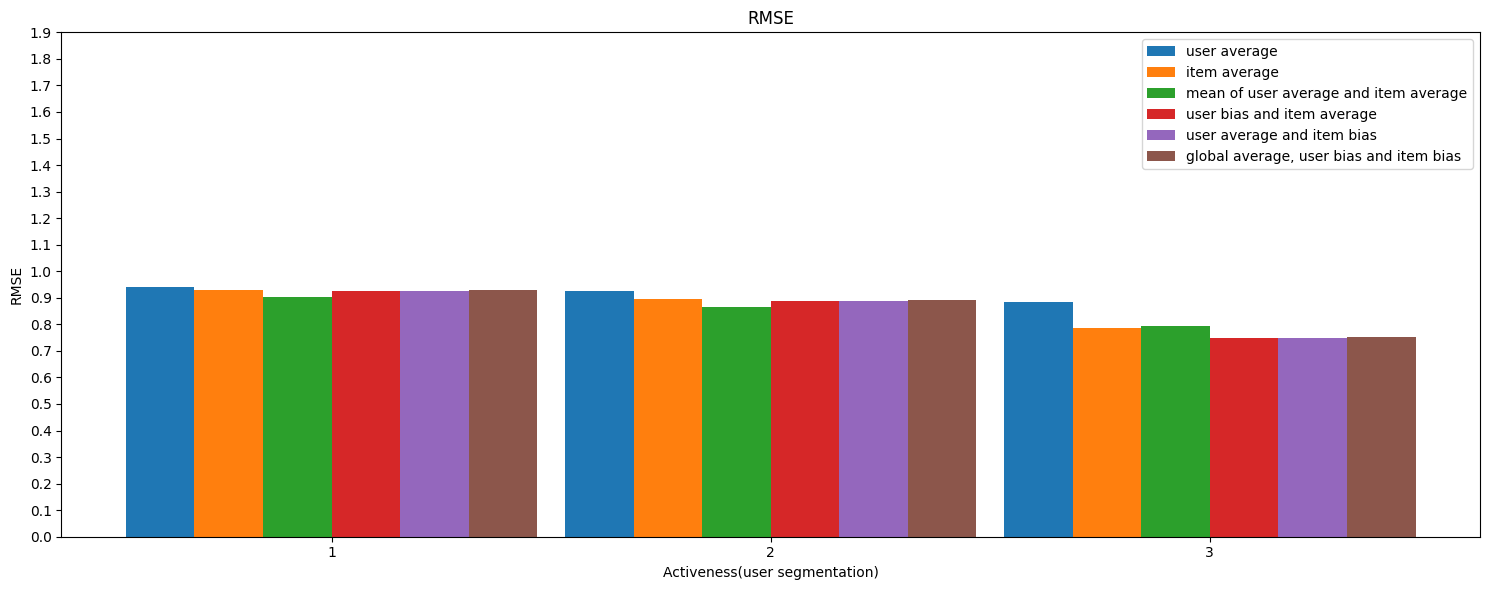

In [22]:
# 类别标签（横坐标）  
categories = ['user average', 'item average', 'mean of user average and item average','user bias and item average','user average and item bias','global average, user bias and item bias']  
  
# 创建一个新的图形  
plt.figure(figsize=(15, 6))  
  
# 绘制柱状图  
bar_width = 0.25  # 每个柱子的宽度  
data = MAE
# index = np.arange(len(data[0]))  # 索引用于柱子的位置  
index = [0,1.6,3.2]
index = np.array(index)
for i, row in enumerate(data):  
    plt.bar(index + i * bar_width, row, bar_width, label=categories[i])  
#     if i==3:
#         break
  
# 设置x轴的刻度标签和位置  
plt.xticks(index + (len(data) - 1) * bar_width / 2, ['1', '2', '3'])  
plt.yticks([round(i*0.1,1) for i in range(20)])
# 添加标题和轴标签  
plt.title('RMSE')  
plt.xlabel('Activeness(user segmentation)')  
plt.ylabel('RMSE')  
plt.legend()  # 显示图例  
  
# 显示图形  
plt.tight_layout()  # 确保标签和图例不会重叠  
plt.show()

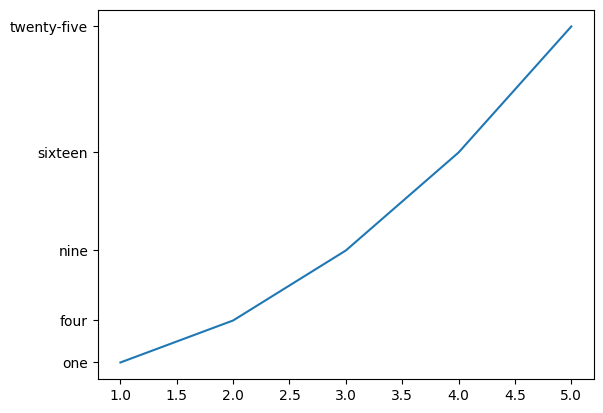

In [8]:
plt.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])  
  
# 设置 y 轴上的刻度位置和标签  
plt.yticks([1, 4, 9, 16, 25], ['one', 'four', 'nine', 'sixteen', 'twenty-five'])  
  
plt.show()

In [16]:
[round(i*0.1,1) for i in range(15)]

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]

In [2]:
train_data = pd.read_csv("datasets/ml-100k/u1.base",sep='\t',names=['uid','iid','rating'],usecols=[0,1,2],header=None)

In [3]:
rating = train_data.values

In [17]:
rating[:,0] == int(1) & (rating[:,2] == 3)

array([False,  True, False, ..., False, False, False])

In [7]:
rating

array([[   1,    1,    5],
       [   1,    2,    3],
       [   1,    3,    4],
       ...,
       [ 943, 1188,    3],
       [ 943, 1228,    3],
       [ 943, 1330,    3]])

In [15]:
rating[:,2] == 3

array([False,  True, False, ...,  True,  True,  True])

In [7]:
np.array([]) -1

array([], dtype=float64)